In [11]:
import pandas as pd
import numpy as np
import h5py
import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from joypy import joyplot
from scipy.stats import mannwhitneyu
from upsetplot import UpSet, from_memberships

In [12]:
expressolog_data = pd.read_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/BasalGanglia/cross_species/expressologs/expressologs_AllGene.csv")
auroc_data = pd.read_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/BasalGanglia/cross_species/expressologs/expressologs_AllGene_with_auroc.csv")

auroc_data_unique = auroc_data.drop_duplicates(subset = "gene")
auroc_data_unique = auroc_data_unique.dropna(subset=["auroc"])
print(auroc_data_unique.head())

    Unnamed: 0     gene            species1      species2  sp1_expr_stat  \
0            1    GPR17  Callithrix jacchus  Homo sapiens       0.792033   
6            7  ANKRD66  Callithrix jacchus  Homo sapiens       0.408358   
12          13  FAM183A  Callithrix jacchus  Homo sapiens       0.000000   
18          19    MYCT1  Callithrix jacchus  Homo sapiens       0.199647   
24          25     CHAT  Callithrix jacchus  Homo sapiens       1.176577   

    sp2_expr_stat  expr_cor  sp_order  median_cor     rank     auroc  
0        0.839082  0.999179         1    0.999261  17206.0  0.862413  
6        0.123265  0.997236         1    0.998150  17205.0  0.862363  
12       0.437974       NaN         1    0.997854  17204.0  0.862313  
18       0.313798  0.995852         1    0.996897  17203.0  0.862263  
24       0.790364  0.996864         1    0.996864  17202.0  0.862212  


In [ ]:
## Genes of interest (Diseases Associations):
sheet_id = "11oP8UJAEofMAzROBXA0sFL90YaKX98-JvVZQIWrHim4"
gid = "1099480292" 
url_csv = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

genes_diseases = pd.read_csv(url_csv, skiprows = 2)
print(genes_diseases.head(10))

               PHENOTYPE                                 PUBLICATION  \
0                    NaN                                         NaN   
1      Neurodegenerative                                         NaN   
2                     PD                                      Kim JJ   
3                     AD      Bellenguez et al (used by Ducan et al)   
4    Amyotrophic lateral                          Van Rheenen et al.   
5        Sustance Abuses                                         NaN   
6       Alcohol per week     Saunders et al. (used by Duncan et al.)   
7  Alcohol Use Disorders  Sanchez-Roige et al. (used by Ducan et al)   
8     Cocaïne Dependence                     Cabana-Domínguez et al.   
9           Cannabis Use                              Johnson et al.   

                                     URL_Publication  \
0                                                NaN   
1                                                NaN   
2  https://www.nature.com/articles/s415

Phenotype
Epilepsy               0.754900
Bipolar Disorder       0.626535
Depression_PGC_2025    0.615408
SCZ                    0.606636
AD                     0.509072
All Genes              0.431232
Alcohol per week       0.429953
Name: auroc, dtype: float64


/home/alma.dubuc/miniconda3/envs/python_env/lib/python3.10/site-packages/joypy/joyplot.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


Alcohol per week
AD
SCZ
Depression_PGC_2025
Bipolar Disorder
Epilepsy
All Genes


<Figure size 1000x600 with 0 Axes>

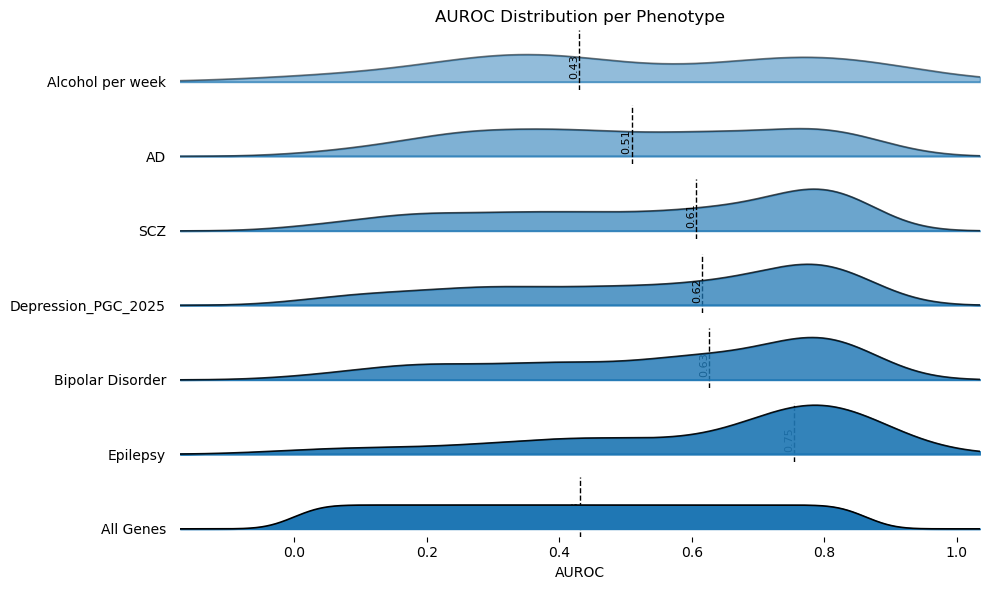

In [ ]:
phenotypes = ["AD", "SCZ", "Alcohol per week", "Depression_PGC_2025", "Bipolar Disorder", "PTSD", "Epilepsy"]
all_pheno_rows = []

for phenotype in phenotypes:
    gene_set_raw = genes_diseases.loc[genes_diseases["PHENOTYPE"] == phenotype, "Genes_combined_publication_Zeighami"] #"All_genes_combined", "Genes_combined_publication_Zeighami"
    
    # Split and clean
    split_genes = [g.strip() for entry in gene_set_raw for g in entry.split(',')]
    gene_set = list(set(split_genes))  # unique
    
    # Diseases-specific genes
    disease_specific = auroc_data_unique[auroc_data_unique["gene"].isin(gene_set)]
    disease_specific = disease_specific[["gene", "auroc"]].copy()
    disease_specific["Phenotype"] = phenotype
    
    all_pheno_rows.append(disease_specific)


# To keep all genes as a baseline as well:
all_genes_df = auroc_data_unique[["gene", "auroc"]].copy()
all_genes_df["Phenotype"] = "All Genes"
all_pheno_rows.append(all_genes_df)


plot_df = pd.concat(all_pheno_rows, ignore_index=True)

medians = plot_df.groupby("Phenotype")["auroc"].median().sort_values(ascending=False)
print(medians)

ordered_phenos = ["All Genes"] + sorted(
    [p for p in medians.index if p != "All Genes"],
    key=lambda p: -medians[p]
)
ordered_phenos = ordered_phenos[::-1]

# Force the order of the phenotypes
plot_df["Phenotype"] = pd.Categorical(plot_df["Phenotype"], categories=ordered_phenos, ordered=True)

# Ridge Plot with Joypy
plt.figure(figsize=(10, 6))
fig, axes = joyplot(
    plot_df,
    by="Phenotype",
    column="auroc",
    figsize=(10, 6),
    kind="kde",
    overlap=0.4,
    fade=True,
    linewidth=1.2
)

for ax, phenotype in zip(axes, ordered_phenos):
    print(phenotype)
    median_value = medians[phenotype]
    ax.axvline(median_value, color='black', linestyle='--', linewidth=1)
    y_max = ax.get_ylim()[1]
    y_pos = y_max * 0.05
    ax.text(median_value, y_pos, f"{median_value:.2f}", 
            fontsize=8, rotation=90, va='bottom', ha='right')
    
    
plt.title("AUROC Distribution per Phenotype")
plt.xlabel("AUROC")
plt.tight_layout()
#plt.savefig("ridgeplot_auroc_by_phenotype.pdf")
plt.show()

In [15]:
## STATISTICAL TESTS:

auroc_all = plot_df[plot_df["Phenotype"] == "All Genes"]["auroc"]

pvals_mw = {}
for phenotype in ordered_phenos:
    if phenotype == "All Genes":
        continue
    auroc_pheno = plot_df[plot_df["Phenotype"] == phenotype]["auroc"]
    stat, pval = mannwhitneyu(auroc_all, auroc_pheno, alternative='two-sided')
    pvals_mw[phenotype] = pval
    print(f"{phenotype}: MW p-value = {pval:.4e}")


Alcohol per week: MW p-value = 8.0736e-02
AD: MW p-value = 8.7583e-06
SCZ: MW p-value = 9.8443e-38
Depression_PGC_2025: MW p-value = 4.0859e-24
Bipolar Disorder: MW p-value = 2.9555e-27
Epilepsy: MW p-value = 6.3970e-13


In [16]:
## Number of genes per phenotype:

for pheno in plot_df["Phenotype"].unique():
    print(f"Nb of genes for {pheno}")    
    print(plot_df[plot_df["Phenotype"] == pheno].shape)

Nb of genes for AD
(198, 3)
Nb of genes for SCZ
(792, 3)
Nb of genes for Alcohol per week
(29, 3)
Nb of genes for Depression_PGC_2025
(451, 3)
Nb of genes for Bipolar Disorder
(406, 3)
Nb of genes for Epilepsy
(81, 3)
Nb of genes for All Genes
(17206, 3)


In [17]:
## TOP GENES: 

for pheno in plot_df["Phenotype"].unique():
    print(pheno)
    print(plot_df[plot_df["Phenotype"] == pheno].head(10))

AD
     gene     auroc Phenotype
0  OPALIN  0.857150        AD
1   FOXF1  0.853441        AD
2  MS4A4A  0.853090        AD
3    CD33  0.852789        AD
4    IQCD  0.851787        AD
5     NPY  0.851687        AD
6    DRC3  0.849431        AD
7      TF  0.846674        AD
8     INS  0.845221        AD
9   SNX22  0.843667        AD
SCZ
        gene     auroc Phenotype
198     CHAT  0.862212       SCZ
199    OLIG2  0.861912       SCZ
200      MOG  0.861561       SCZ
201  SLC17A6  0.861060       SCZ
202     LHX6  0.860809       SCZ
203    CLDN5  0.860659       SCZ
204  SLC18A2  0.860408       SCZ
205      MAG  0.859606       SCZ
206  ADORA2A  0.859355       SCZ
207  PPP1R1B  0.858854       SCZ
Alcohol per week
        gene     auroc         Phenotype
990     CHAT  0.862212  Alcohol per week
991     IL18  0.841161  Alcohol per week
992   GABRA1  0.839908  Alcohol per week
993    CHRM2  0.837853  Alcohol per week
994    KCNJ6  0.816851  Alcohol per week
995     BDNF  0.785374  Alcohol per w

/home/alma.dubuc/miniconda3/envs/python_env/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/alma.dubuc/miniconda3/envs/python_env/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original objec

<Figure size 1000x600 with 0 Axes>

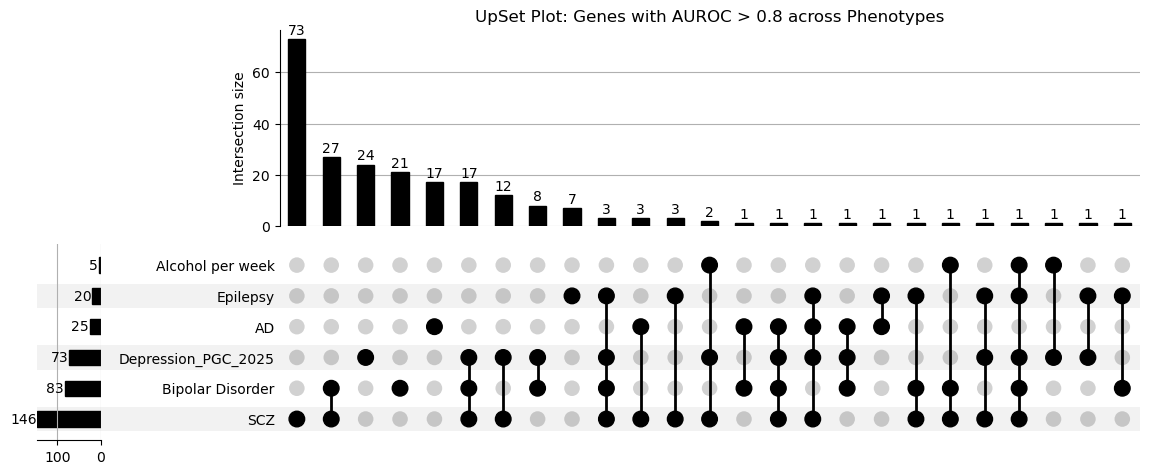

In [ ]:
## Gene-sets Overlaps and Upset Plots: 

# Filter genes with AUROC > 0.8
filtered_df = plot_df[(plot_df["auroc"] > 0.8) & (plot_df["Phenotype"] != "All Genes")]

# Dict: phenotype → gene-sets
pheno_to_genes = {
    pheno: set(filtered_df[filtered_df["Phenotype"] == pheno]["gene"])
    for pheno in filtered_df["Phenotype"].unique()
}

# Input Format for Upset Plot
gene_memberships = {}

for pheno, gene_set in pheno_to_genes.items():
    for gene in gene_set:
        gene_memberships.setdefault(gene, set()).add(pheno)

memberships = list(gene_memberships.values())
data = from_memberships(memberships)


# Plot the UpsetPlot
plt.figure(figsize=(10, 6))
UpSet(data, subset_size='count', show_counts=True, sort_by='cardinality').plot()
plt.title("UpSet Plot: Genes with AUROC > 0.8 across Phenotypes")
plt.tight_layout()
plt.show()
